In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np





# === 1. Ler o CSV ===
df = pd.read_csv("bank_marketing/bank.csv", sep=";")

# === 2. Eliminar duplicados ===
df.drop_duplicates(inplace=True)

# === 3. Normalizar nomes das colunas ===
df.columns = df.columns.str.strip().str.lower()

print(f"Número de linhas: {len(df)}")

# === 4. Verificar percentagem de 'unknown' ===
percentagem_unknown = (df == "unknown").sum() * 100 / len(df)
print("\nPercentagem de 'unknown' por coluna:")
print(percentagem_unknown)

# === 5. Tratar 'unknown' (substituir pelo modo) ===
for col in ['job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome']:
    if df[col].dtype == 'object':
        df[col] = df[col].replace('unknown', df[col].mode()[0])

# === 6. Converter meses e dias ===
month_mapping = {
    "jan": 1, "feb": 2, "mar": 3, "apr": 4, "may": 5, "jun": 6,
    "jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12
}
df["month_ordinal"] = df["month"].map(month_mapping)

# One-hot encoding para meses e dias da semana
df = pd.get_dummies(df, columns=["month", "day_of_week"], prefix=["month", "day"], drop_first=True)

# === 7. Explorar colunas informativas ===
print(f"\nPercentagem de 'nonexistent' em 'poutcome': {(df['poutcome'] == 'nonexistent').mean() * 100:.2f}%")
print(f"Percentagem de '0' em 'duration': {(df['duration'] == 0).mean() * 100:.2f}%")
print(f"Percentagem de '999' em 'pdays': {(df['pdays'] == 999).mean() * 100:.2f}%")

# === 8. Eliminar colunas irrelevantes ===
# Duration: não conhecida antes da chamada
# Pdays: muitos 999 (sem informação útil)
df.drop(columns=["duration", "pdays"], inplace=True)

# === 9. Converter variável alvo ===
print("\nDistribuição da variável alvo (y):")
print(df["y"].value_counts(normalize=True) * 100)

df["y"] = df["y"].map({"yes": 1, "no": 0})

# === 10. Separar features e target ===
X = df.drop(columns=["y"])
y = df["y"]

# === 11. Escalonar variáveis numéricas ===
num_cols = ['age', 'campaign', 'previous', 
             'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 
             'euribor3m', 'nr.employed']

# StandardScaler (normalmente melhor que MinMax neste dataset)
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# === 12. Codificar variáveis categóricas ===
X = pd.get_dummies(X, columns=[
    'job', 'marital', 'education', 'default', 
    'housing', 'loan', 'contact', 'poutcome'
], drop_first=True)

# === 13. Verificar valores nulos ===
print("\nValores nulos por coluna:")
print(X.isnull().sum())



# Identificar features altamente correlacionadas
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print("Features muito correlacionadas (remover):", to_drop)
#Features muito correlacionadas (remover): ['euribor3m', 'nr.employed']
# Remover
X = X.drop(columns=to_drop)

X.head()

Número de linhas: 41176

Percentagem de 'unknown' por coluna:
age                0.000000
job                0.801438
marital            0.194288
education          4.201477
default           20.876239
housing            2.404313
loan               2.404313
contact            0.000000
month              0.000000
day_of_week        0.000000
duration           0.000000
campaign           0.000000
pdays              0.000000
previous           0.000000
poutcome           0.000000
emp.var.rate       0.000000
cons.price.idx     0.000000
cons.conf.idx      0.000000
euribor3m          0.000000
nr.employed        0.000000
y                  0.000000
dtype: float64

Percentagem de 'nonexistent' em 'poutcome': 86.34%
Percentagem de '0' em 'duration': 0.01%
Percentagem de '999' em 'pdays': 96.32%

Distribuição da variável alvo (y):
y
no     88.733728
yes    11.266272
Name: proportion, dtype: float64

Valores nulos por coluna:
age                              0
campaign                         0
p

,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,month_ordinal,month_aug,month_dec,month_jul,...,education_high.school,education_illiterate,education_professional.course,education_university.degree,default_yes,housing_yes,loan_yes,contact_telephone,poutcome_nonexistent,poutcome_success
0,1.533143,-0.565963,-0.349551,0.648101,0.722628,0.886568,5,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1,1.629107,-0.565963,-0.349551,0.648101,0.722628,0.886568,5,False,False,False,...,True,False,False,False,False,False,False,True,True,False
2,-0.290177,-0.565963,-0.349551,0.648101,0.722628,0.886568,5,False,False,False,...,True,False,False,False,False,True,False,True,True,False
3,-0.002284,-0.565963,-0.349551,0.648101,0.722628,0.886568,5,False,False,False,...,False,False,False,False,False,False,False,True,True,False
4,1.533143,-0.565963,-0.349551,0.648101,0.722628,0.886568,5,False,False,False,...,True,False,False,False,False,False,True,True,True,False


In [38]:

corr_matrix = X.corr().abs()  # matriz de correlação absoluta
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(to_drop)
X = X.drop(columns=to_drop)

X.head()

[]


,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,month_ordinal,month_aug,month_dec,month_jul,...,education_high.school,education_illiterate,education_professional.course,education_university.degree,default_yes,housing_yes,loan_yes,contact_telephone,poutcome_nonexistent,poutcome_success
0,1.533143,-0.565963,-0.349551,0.648101,0.722628,0.886568,5,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1,1.629107,-0.565963,-0.349551,0.648101,0.722628,0.886568,5,False,False,False,...,True,False,False,False,False,False,False,True,True,False
2,-0.290177,-0.565963,-0.349551,0.648101,0.722628,0.886568,5,False,False,False,...,True,False,False,False,False,True,False,True,True,False
3,-0.002284,-0.565963,-0.349551,0.648101,0.722628,0.886568,5,False,False,False,...,False,False,False,False,False,False,False,True,True,False
4,1.533143,-0.565963,-0.349551,0.648101,0.722628,0.886568,5,False,False,False,...,True,False,False,False,False,False,True,True,True,False


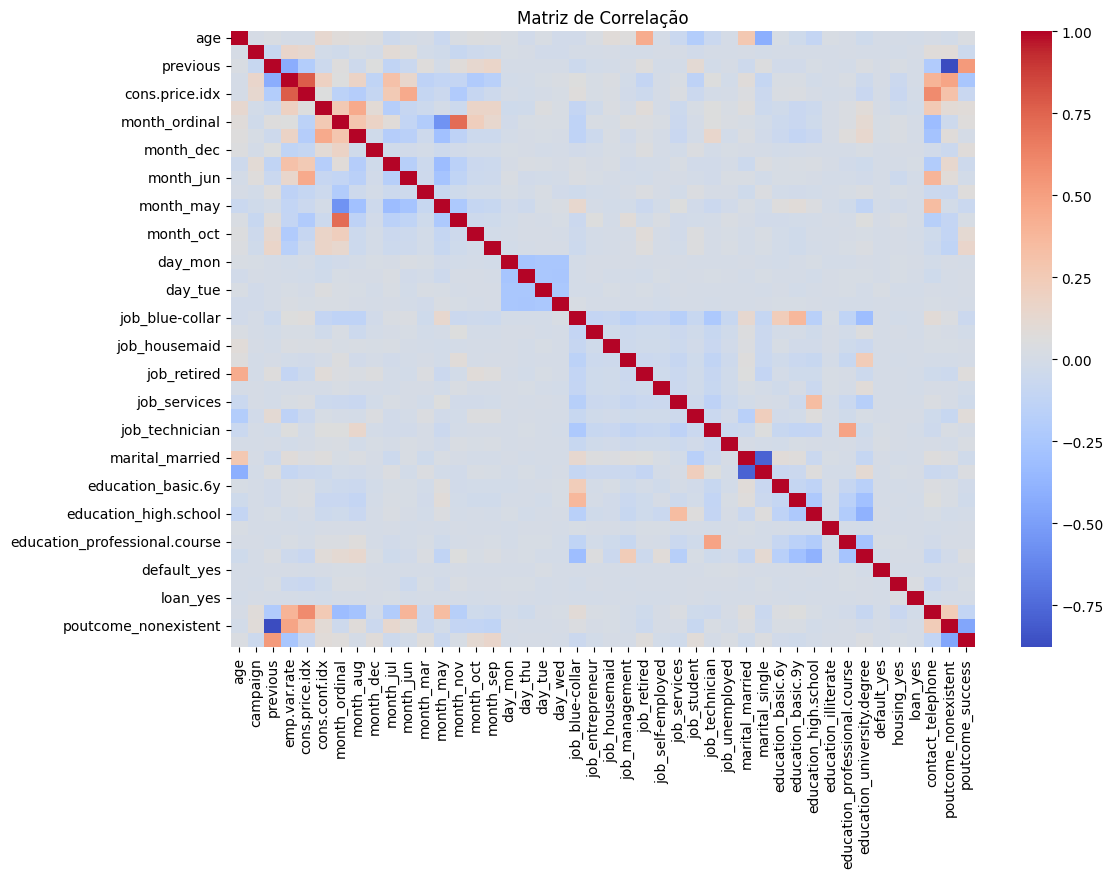

In [39]:


corr = X.corr(numeric_only=True)

plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Matriz de Correlação")
plt.show()





Features muito correlacionadas (remover): ['euribor3m', 'nr.employed']


y                                1.000000
poutcome_success                 0.316302
previous                         0.230202
month_mar                        0.144027
month_oct                        0.137538
month_sep                        0.126079
job_student                      0.093962
job_retired                      0.092364
month_dec                        0.079311
education_university.degree      0.057614
cons.conf.idx                    0.054802
marital_single                   0.054209
month_ordinal                    0.037210
age                              0.030381
job_unemployed                   0.014749
day_thu                          0.013797
housing_yes                      0.011145
day_tue                          0.008123
education_illiterate             0.007246
day_wed                          0.006290
education_professional.course    0.001071
job_management                  -0.000426
default_yes                     -0.003042
loan_yes                        -0

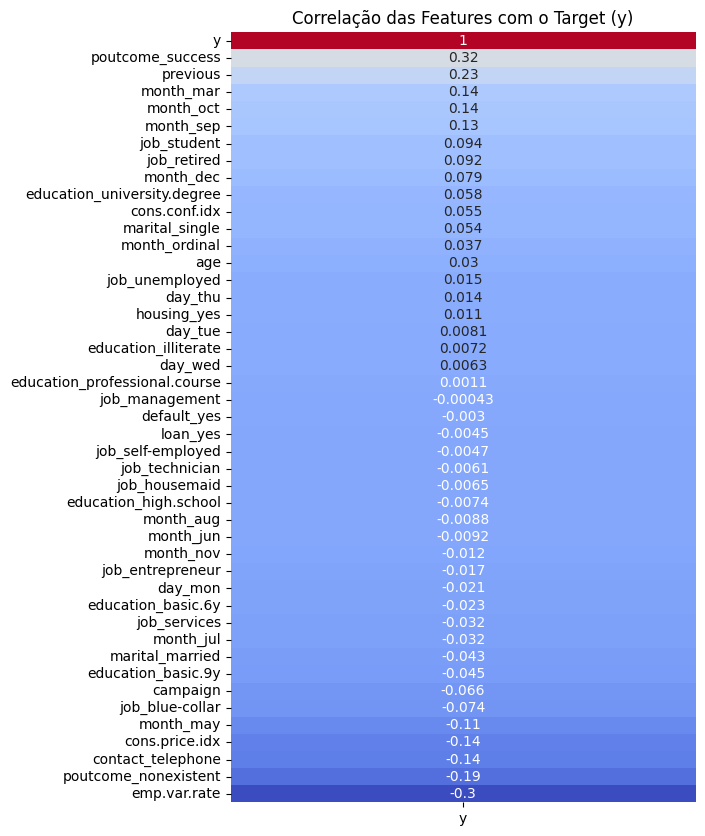

In [41]:
# Combinar X e y num único DataFrame temporário
df_temp = X.copy()
df_temp['y'] = y

# Calcular correlação apenas para colunas numéricas
corr_with_target = df_temp.corr(numeric_only=True)['y'].sort_values(ascending=False)

print(corr_with_target)

##remover as featuras muito perto de 0 
# cons.conf.idx, cons.price.idx, euribor3m, nr.employed, emp.var.rate

plt.figure(figsize=(6,10))
sns.heatmap(corr_with_target.to_frame(), annot=True, cmap="coolwarm", cbar=False)
plt.title("Correlação das Features com o Target (y)")
plt.show()

Top 15 features mais importantes (Random Forest):
age                            0.320526
campaign                       0.125220
poutcome_success               0.061695
cons.conf.idx                  0.055624
emp.var.rate                   0.047502
housing_yes                    0.041561
cons.price.idx                 0.040485
education_university.degree    0.029747
previous                       0.026609
day_thu                        0.025508
month_ordinal                  0.024328
day_tue                        0.024181
day_wed                        0.023061
marital_married                0.022025
contact_telephone              0.019062
dtype: float64


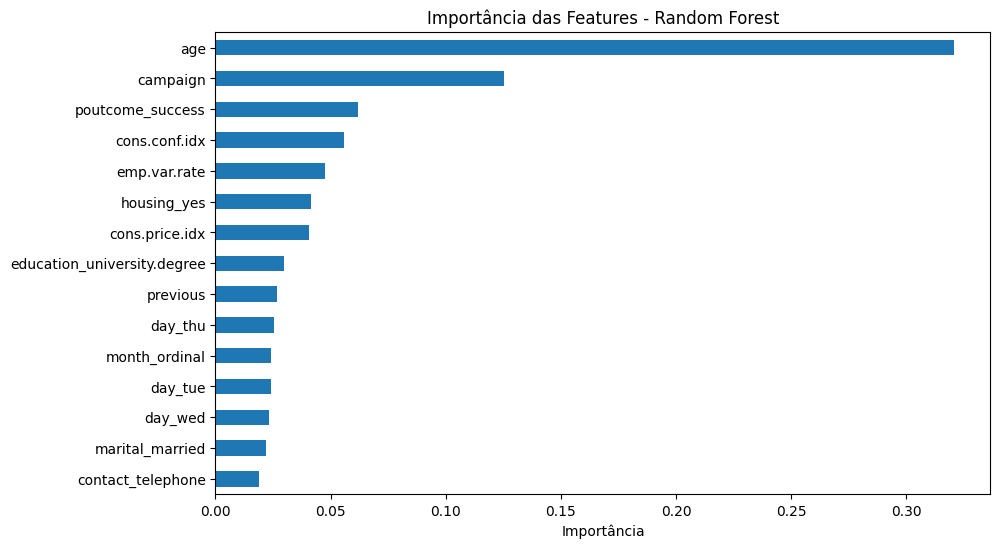

In [46]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



# Criar e treinar o modelo
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Obter importância das features
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

# Mostrar as top 15 features mais importantes
print("Top 15 features mais importantes (Random Forest):")
print(importances.head(15))

# Visualizar graficamente
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
importances.head(15).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Importância das Features - Random Forest")
plt.xlabel("Importância")
plt.show()

In [49]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
rfe = RFE(model, n_features_to_select=10)
rfe.fit(X, y)
print("Features selecionadas:", X.columns[rfe.support_])

Features selecionadas: Index(['campaign', 'poutcome_success', 'cons.conf.idx', 'emp.var.rate',
       'cons.price.idx', 'education_university.degree', 'day_thu', 'day_tue',
       'day_wed', 'contact_telephone'],
      dtype='object')


In [51]:
selected_features = list(set(
    ['campaign', 'poutcome_success', 'cons.conf.idx', 'emp.var.rate',
     'cons.price.idx', 'education_university.degree', 'day_thu', 'day_tue',
     'day_wed', 'contact_telephone'] + 
    ['age', 'campaign', 'poutcome_success', 'cons.conf.idx', 'emp.var.rate',
     'housing_yes', 'cons.price.idx', 'education_university.degree', 'previous',
     'day_thu', 'month_ordinal', 'day_tue', 'day_wed', 'marital_married',
     'contact_telephone']
))

X = X[selected_features].copy()
print(X.shape)
print(X.columns)


(41176, 15)
Index(['emp.var.rate', 'marital_married', 'housing_yes', 'previous',
       'cons.conf.idx', 'poutcome_success', 'age',
       'education_university.degree', 'day_tue', 'day_wed', 'day_thu',
       'contact_telephone', 'campaign', 'cons.price.idx', 'month_ordinal'],
      dtype='object')


In [23]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 1. Separar treino e teste primeiro
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# 2. Aplicar SMOTE apenas no treino
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# O teste fica igual — nunca se mexe!


Número de linhas: 41176

Colunas e tipos de dados:
age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

Resumo estatístico das colunas numéricas:
               age      duration      campaign         pdays      previous  \
count  41176.00000  41176.000000  41176.000000  41176.000000  41176.000000   
mean      40.02380    258.315815      2.567879    962.464810      0.173013   
std       10.42068    259.305321      2.770318    186.937102      0.494964   
min       17.00000      0.000000  

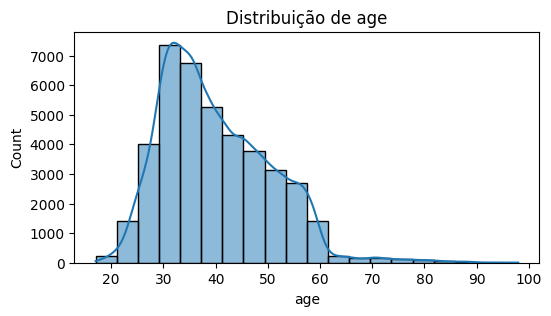

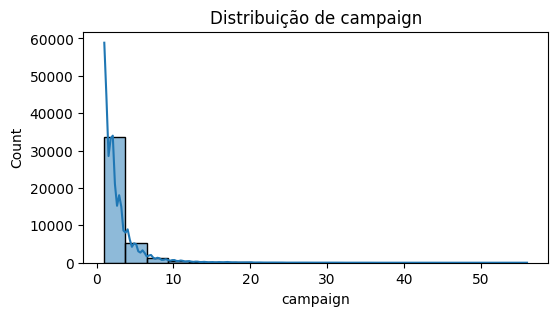

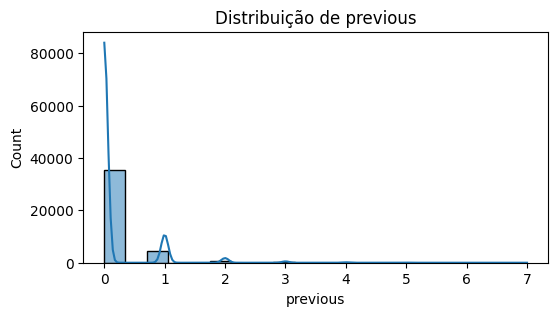

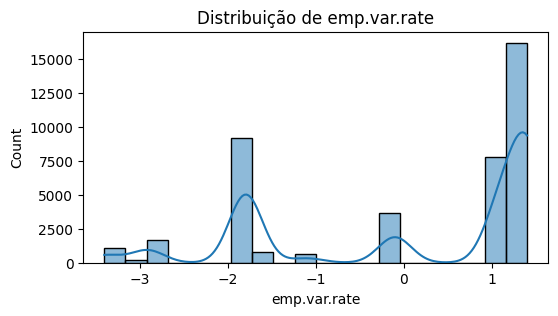

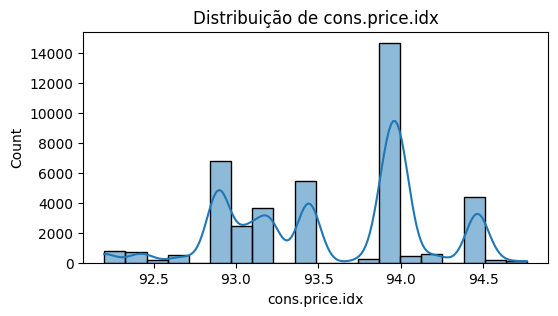

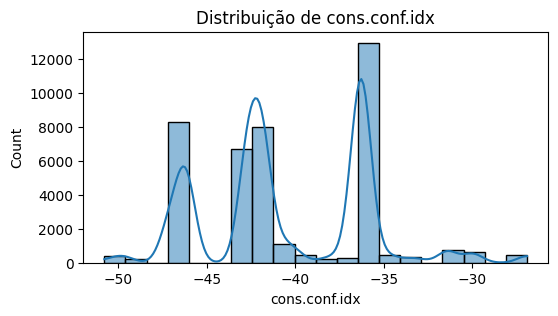

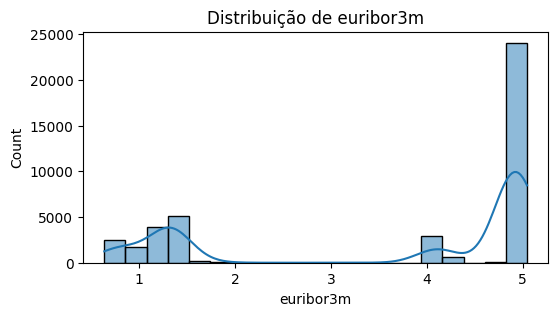

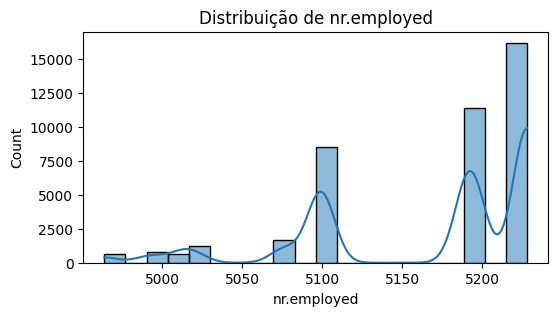

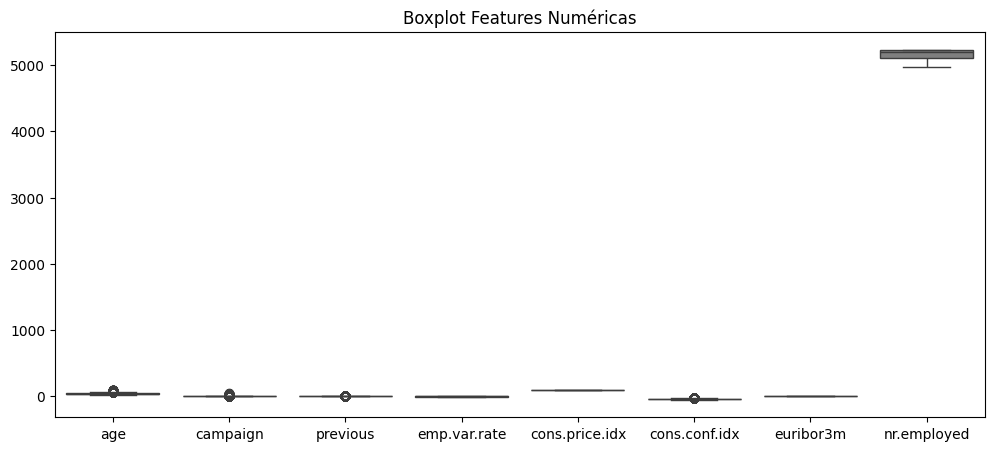


Features removidas por alta correlação: ['euribor3m', 'nr.employed']

Top 15 features selecionadas para modelagem:
['age', 'campaign', 'poutcome_success', 'cons.conf.idx', 'housing_yes', 'emp.var.rate', 'cons.price.idx', 'loan_yes', 'previous', 'day_of_week_thu', 'month_ordinal', 'marital_married', 'day_of_week_mon', 'day_of_week_wed', 'day_of_week_tue']

Shape treino original: (32940, 15)
Shape treino após SMOTE: (58458, 15)

--- RANDOM FOREST ---
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      7308
           1       0.34      0.40      0.37       928

    accuracy                           0.84      8236
   macro avg       0.63      0.65      0.64      8236
weighted avg       0.86      0.84      0.85      8236

AUC: 0.7446848369996036


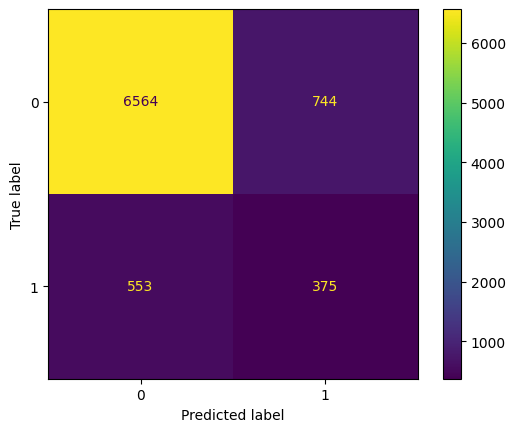

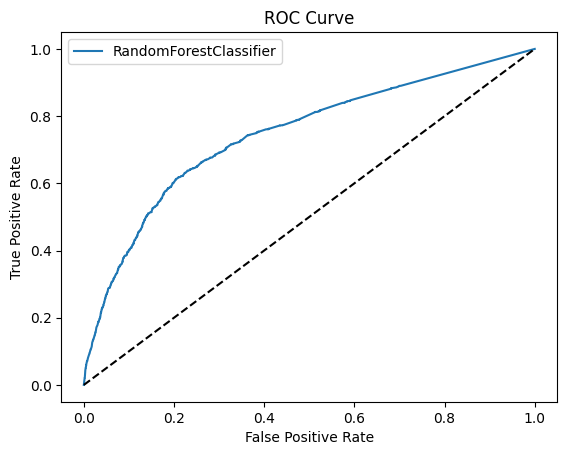


--- LOGISTIC REGRESSION ---
              precision    recall  f1-score   support

           0       0.95      0.80      0.87      7308
           1       0.29      0.67      0.41       928

    accuracy                           0.78      8236
   macro avg       0.62      0.73      0.64      8236
weighted avg       0.88      0.78      0.81      8236

AUC: 0.7715055713625125


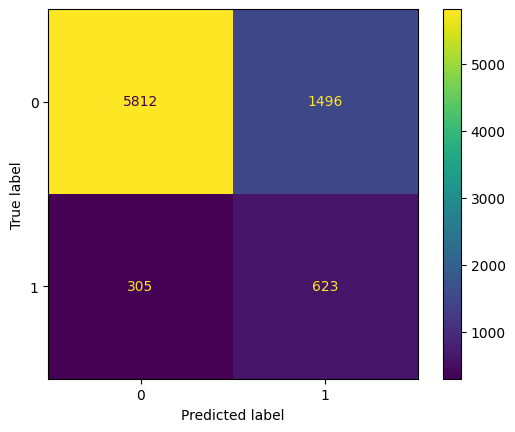

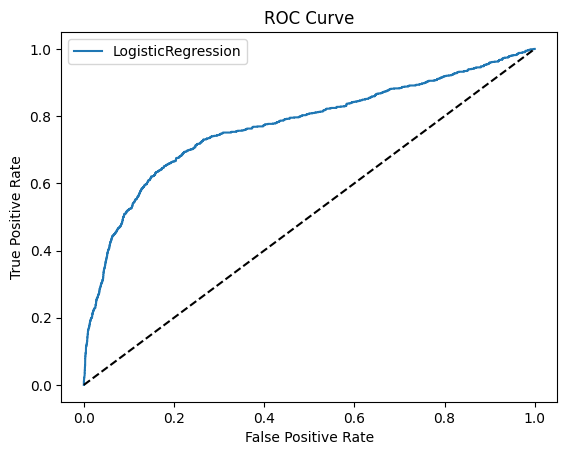

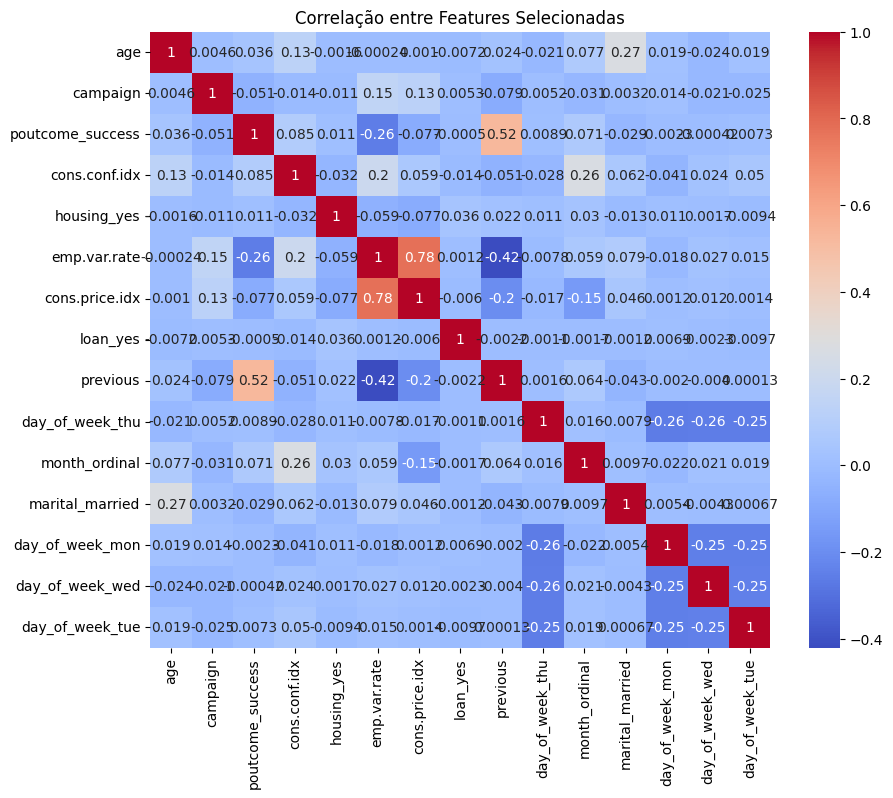

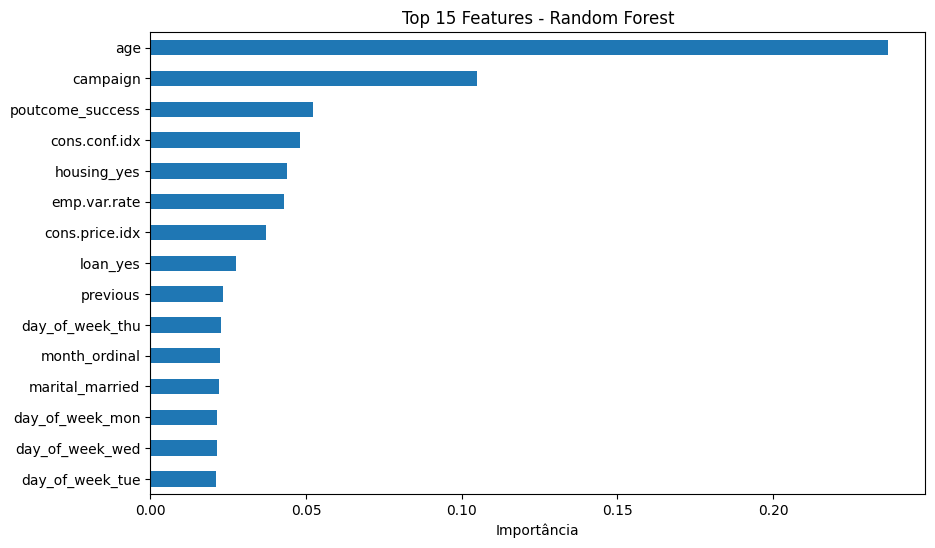

A feature 'age' tem importância 0.237 no modelo Random Forest.
A feature 'campaign' tem importância 0.105 no modelo Random Forest.
A feature 'poutcome_success' tem importância 0.052 no modelo Random Forest.
A feature 'cons.conf.idx' tem importância 0.048 no modelo Random Forest.
A feature 'housing_yes' tem importância 0.044 no modelo Random Forest.
A feature 'emp.var.rate' tem importância 0.043 no modelo Random Forest.
A feature 'cons.price.idx' tem importância 0.037 no modelo Random Forest.
A feature 'loan_yes' tem importância 0.028 no modelo Random Forest.
A feature 'previous' tem importância 0.023 no modelo Random Forest.
A feature 'day_of_week_thu' tem importância 0.023 no modelo Random Forest.


In [1]:
# VERSAO DO CHATGPT ===============================
# IMPORTS
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from imblearn.over_sampling import SMOTE

# ===============================
# 1. LEITURA E DESCRIÇÃO INICIAL
# ===============================
df = pd.read_csv("bank_marketing/bank.csv", sep=";")
df.drop_duplicates(inplace=True)
df.columns = df.columns.str.strip().str.lower()

print(f"Número de linhas: {len(df)}")
print("\nColunas e tipos de dados:")
print(df.dtypes)
print("\nResumo estatístico das colunas numéricas:")
print(df.describe())

# ===============================
# 2. EXPLORATORY DATA ANALYSIS (EDA)
# ===============================
# Percentagem de 'unknown'
percent_unknown = (df=='unknown').sum()*100/len(df)
print("\nPercentagem de 'unknown' por coluna:")
print(percent_unknown)

# Distribuição do target
target_dist = df['y'].value_counts(normalize=True)*100
print("\nDistribuição da variável alvo 'y':")
print(target_dist)

# Gráficos automáticos para features numéricas
num_cols = ['age','campaign','previous','emp.var.rate','cons.price.idx',
            'cons.conf.idx','euribor3m','nr.employed']

for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f"Distribuição de {col}")
    plt.show()

# Boxplots para outliers
plt.figure(figsize=(12,5))
sns.boxplot(data=df[num_cols])
plt.title("Boxplot Features Numéricas")
plt.show()

# ===============================
# 3. LIMPEZA E TRANSFORMAÇÃO
# ===============================
# Substituir 'unknown' pelo modo
for col in ['job','marital','education','default','housing','loan','poutcome']:
    df[col] = df[col].replace('unknown', df[col].mode()[0])

# Converter meses para ordinal
month_map = {"jan":1,"feb":2,"mar":3,"apr":4,"may":5,"jun":6,
             "jul":7,"aug":8,"sep":9,"oct":10,"nov":11,"dec":12}
df['month_ordinal'] = df['month'].map(month_map)

# One-hot encoding para meses e dias
df = pd.get_dummies(df, columns=['month','day_of_week'], drop_first=True)

# Remover colunas irrelevantes
df.drop(columns=['duration','pdays'], inplace=True)

# Converter target para binário
df['y'] = df['y'].map({'yes':1,'no':0})

# ===============================
# 4. FEATURE SELECTION
# ===============================
X = df.drop(columns=['y'])
y = df['y']

# Escalonamento
scaler = StandardScaler()
num_cols_scaled = ['age','campaign','previous','emp.var.rate','cons.price.idx',
                   'cons.conf.idx','euribor3m','nr.employed']
X[num_cols_scaled] = scaler.fit_transform(X[num_cols_scaled])

# One-hot encoding para categóricas restantes
cat_cols = ['job','marital','education','default','housing','loan','contact','poutcome']
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Remover features muito correlacionadas
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col]>0.9)]
X.drop(columns=to_drop, inplace=True)
print("\nFeatures removidas por alta correlação:", to_drop)

# Random Forest para importância de features
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
top_features = importances.head(15).index.tolist()
X = X[top_features]
print("\nTop 15 features selecionadas para modelagem:")
print(top_features)

# ===============================
# 5. TREINO/TESTE + SMOTE
# ===============================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nShape treino original:", X_train.shape)
print("Shape treino após SMOTE:", X_train_res.shape)

# ===============================
# 6. FUNÇÃO DE AVALIAÇÃO
# ===============================
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    
    print(classification_report(y_test, y_pred))
    print("AUC:", roc_auc_score(y_test, y_proba))
    
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.show()
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=model.__class__.__name__)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# ===============================
# 7. TREINAR E AVALIAR MODELOS
# ===============================
print("\n--- RANDOM FOREST ---")
rf_model = RandomForestClassifier(random_state=42)
evaluate_model(rf_model, X_train_res, y_train_res, X_test, y_test)

print("\n--- LOGISTIC REGRESSION ---")
lr_model = LogisticRegression(max_iter=1000)
evaluate_model(lr_model, X_train_res, y_train_res, X_test, y_test)

# ===============================
# 8. GRÁFICOS FINAIS
# ===============================
# Heatmap das features selecionadas
plt.figure(figsize=(10,8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title("Correlação entre Features Selecionadas")
plt.show()

# Importância das features Random Forest
plt.figure(figsize=(10,6))
importances.head(15).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 15 Features - Random Forest")
plt.xlabel("Importância")
plt.show()

# Interpretação textual rápida
for feature, importance in importances.head(10).items():
    print(f"A feature '{feature}' tem importância {importance:.3f} no modelo Random Forest.")
